# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import all the necessary libraries here, including numeric value processing, machine learning libraries and 
# visualization libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
attribute_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attribute_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [4]:
# data shape of both Germany population and customers
print("number of population rows = {}".format(azdias.shape[0]))
print("number of population columns = {}".format(azdias.shape[1]))
print("number of customers rows = {}".format(customers.shape[0]))
print("number of customers columns = {}".format(customers.shape[1]))

number of population rows = 891221
number of population columns = 366
number of customers rows = 191652
number of customers columns = 369


In [5]:
# loading data error fix: DtypeWarning: Columns (18,19) have mixed types
print(azdias.columns[18:20])
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())
print(customers['CAMEO_DEUG_2015'].unique())
print(customers['CAMEO_INTL_2015'].unique())

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43' '22'
 '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33' 'XX']


In [6]:
# replace the X, XX as missing value  np.nan & replace the float type as int.
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X': np.nan})
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX': np.nan})
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace({'X': np.nan})
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace({'XX': np.nan})

In [7]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(float)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype(float)

In [8]:
#take a look at attribute intro file 
attribute_values.reset_index(drop = True, inplace = True)
# not all the variables have unknown value and not all of them note it with 0 or 1
unknown_attributes = attribute_values[(attribute_values['Meaning'] == 'unknown')\
                                       |(attribute_values['Meaning']=='no classification possible')\
                                      |(attribute_values['Meaning']=='no score calculated')\
                                      |(attribute_values['Meaning']=='no transactions known')\
                                      |(attribute_values['Meaning']=='no transaction known')]

In [9]:
unknown_cols = unknown_attributes[['Attribute', 'Value']]
df1=pd.DataFrame.from_records(unknown_cols.values)
#create a dict for unknown values
unknown_dict = df1.set_index(0).T.to_dict('list')

In [10]:
"""function missing_value() will replace -1, 0, 1, 9 etc representing unknonwn value as np.nan for consistancy"""
def missing_value(df):
    for key in unknown_dict:
        try:
            f = lambda x: np.nan if x in list(unknown_dict[key]) else x
            df[key] = df[key].apply(f)
        except:
            continue
            
    return df

In [11]:
azdias = missing_value(azdias)
customers = missing_value(customers)

In [12]:
gap = [col for col in customers.columns if col not in azdias.columns]
gap

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [13]:
# Some variables have a significant amount of unique values, cleaning and grouping them will help with clustering later.
attributes_values = attribute_values.ffill()
attributes_dict = attributes_values.groupby('Attribute')['Value'].count()
excessive_var = [[var,val] for var, val in attributes_dict.items() if val>12]
excessive_var

[['ALTER_HH', 22],
 ['CAMEO_DEUINTL_2015', 26],
 ['CAMEO_DEU_2015', 44],
 ['LP_LEBENSPHASE_FEIN', 40],
 ['PRAEGENDE_JUGENDJAHRE', 16]]

In [14]:
attributes_values[attributes_values['Attribute']=='LP_LEBENSPHASE_FEIN']['Value'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40], dtype=object)

In [15]:
#DE-DUPLICATION and grouping for income and household size for "LP_LEBENSPHASE_FEIN" "LP_LEBENSPHASE_GROB"
def lp_refine(df):
    df1 = df
    age_group = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    income_group = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df1["Temp"] = df1["LP_LEBENSPHASE_FEIN"]
    df1["LP_LEBENSPHASE_FEIN"] = df1["LP_LEBENSPHASE_FEIN"].map(age_group)
    df1["LP_LEBENSPHASE_GROB"] = df1["Temp"].map(income_group)
    age_level = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    income_level = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    df1["LP_LEBENSPHASE_FEIN"] = df1["LP_LEBENSPHASE_FEIN"].map(age_level)
    df1["LP_LEBENSPHASE_GROB"] = df1["LP_LEBENSPHASE_GROB"].map(income_level)
    del df1['Temp']
    return df1

In [16]:
azdias = lp_refine(azdias)
customers = lp_refine(customers)

In [17]:
# even though 'ALTER_HH' HAS more than 20 unique values, since it separates the age group pretty well, we can keep it for now
print(azdias['ALTER_HH'].unique())
#'PRAEGENDE_JUGENDJAHRE' contains some interesting facts about population trait, I will keep it for now
print(azdias['PRAEGENDE_JUGENDJAHRE'].unique())
#CAMEO_DEU_2015 is detailed classification of population, it would be a big workload trying to narrow them into a smaller
#group, I will leave them like this for now untill I need to refine them in the future. 
print(azdias['CAMEO_DEU_2015'].unique())
print(customers['CAMEO_DEU_2015'].unique())

[ nan   0.  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.
   7.  12.   4.   3.   6.   5.   2.   1.]
[ 0 14 15  8  3 10 11  5  9  6  4  2  1 12 13  7]
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D'
 'XX']


In [18]:
# notice there are 'XX' in column 'CAMEO_DEU_2015' too, replace them with np.nan as well. 
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace({'XX': np.nan})
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].replace({'XX': np.nan})

In [19]:
#validation for "LP_LEBENSPHASE_FEIN" "LP_LEBENSPHASE_GROB" regrouping for Customers & azdias dataset
print(azdias['LP_LEBENSPHASE_FEIN'].unique())
print(customers['LP_LEBENSPHASE_GROB'].unique())

[  3.   2.   1.  nan   4.]
[  4.  nan   1.   2.   3.]


In [20]:
"""functin date_refine() refine the time, group them by year of creation"""
def date_refine(df):
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    return df

In [21]:
azdias = date_refine(azdias)
customers = date_refine(customers)

In [22]:
"""Function missing_percentage() takes in a df and returns a df with information about column-wise missing values percentages."""
def missing_percentage(df):

    percentage = df.isnull().sum() /len(df)
    
    percentage_df = pd.DataFrame({"attribute": df.columns,
                                     "percentage": percentage}).reset_index(drop=True)
    return percentage_df

In [23]:
azdias_missing_df = missing_percentage(azdias)
customers_missing_df = missing_percentage(customers)

By trying out different value of missing percentage, 30 percent seems to be the most reasonable threshold. 

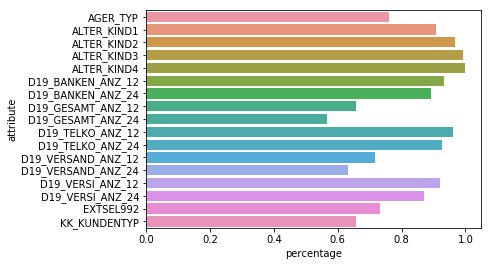

In [24]:
sns.barplot(y="attribute", x="percentage", 
                data=azdias_missing_df[azdias_missing_df['percentage']>0.30])

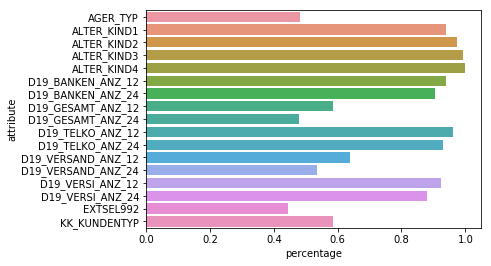

In [25]:
sns.barplot(y="attribute", x="percentage", 
                data=customers_missing_df[customers_missing_df['percentage']>0.30])

In [26]:
print(len(customers_missing_df.loc[customers_missing_df.percentage>0.30]))
print(len(azdias_missing_df.loc[azdias_missing_df.percentage>0.30]))

17
17


In [27]:
col_to_remove_customers = [col for col in customers_missing_df[customers_missing_df['percentage']>0.3]['attribute']]
col_to_remove_azdias = [col for col in azdias_missing_df[azdias_missing_df['percentage']>0.3]['attribute']]
col_to_remove = list(set(col_to_remove_customers+col_to_remove_azdias))

In [28]:
azdias.drop(columns = col_to_remove, inplace = True)
customers.drop(columns = col_to_remove, inplace = True)

In [29]:
# explore the types of data, and convert them into the same type
azdias_object = azdias.columns[azdias.dtypes == "object"]
print(azdias_object)
customers_object = customers.columns[customers.dtypes == "object"]
print(customers_object)

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')
Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')


OST_WEST_KZ is a categorical feature, I will transform {W, O} into {0, 1}

In [30]:
azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].replace({"W": 0, "O": 1})
customers["OST_WEST_KZ"] = customers["OST_WEST_KZ"].replace({"W": 0, "O": 1})
azdias.drop(columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], inplace = True)
customers.drop(columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], inplace = True)

In [31]:
customers.drop(columns = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], inplace = True)

Set the threshold to 300 to delete rows with too many missing data.

In [32]:
print(azdias.shape)
print(customers.shape)
azdias.dropna(thresh = 300, inplace= True)
print(azdias.shape)
customers.dropna(thresh = 300, inplace= True)
print(customers.shape)

(891221, 347)
(191652, 347)
(751331, 347)
(135144, 347)


In [33]:
customers.set_index('LNR')
azdias.set_index('LNR')

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
910248,9.0,0.0,NaN,4.0,0.0,0.0,1.0,3.0,0.0,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
910261,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,0.0,2.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
645145,9.0,16.0,16.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
645153,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,2.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


# Feature Engineering
### 1. imputation (most frequent value)
### 2. standardization

In [34]:
"""function imputation: fill nan with most frequent value in each column"""
def imputation(df):
    for col in df.columns:
        df[col].fillna(df[col].value_counts().index[0], inplace = True)
    return df

In [35]:
azdias = imputation(azdias)
customers = imputation(customers)

In [36]:
customers.isnull().values.any()

False

In [37]:
azdias.to_csv('azdias_cleaned.csv')
customers.to_csv('customers_cleaned.csv')

In [38]:
azdias_cleaned = pd.read_csv('azdias_cleaned.csv')
customers_cleaned = pd.read_csv('customers_cleaned.csv')

In [39]:
del azdias 
del customers

## Standardization
PCA is effected by scale so you need to scale the features in the data before applying PCA. You can transform the data onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. StandardScaler helps standardize the dataset’s features. Note you fit on the training set and transform on the training and test set. 


In [40]:
"""feature engineering"""
# 1. standardization
scaler = StandardScaler()
azdias_cleaned = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

In [41]:
customers_cleaned = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns)

In [42]:
customers_cleaned.drop(columns=['Unnamed: 0'], inplace = True)
azdias_cleaned.drop(columns=['Unnamed: 0'], inplace = True)

In [43]:
print(azdias_cleaned.shape)
print(customers_cleaned.shape)

(751331, 347)
(135144, 347)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality Reduction
We have 347 features in total in general population and customers. However not all of them have meaningful variation, i.e. Collinearity. Also tiny variation within the feature could happen, even some features will remain the same for all the people. A systematic approach should be addressed to perform dimensionality reduction. Here I would leverage Principle Component Analysis (PCA) to decide which feature to keep, which feature to drop. The gist of using PCA is to apply a linear transformation on the data and get the ratio of explained variance. By setting a threshold, for my case here, I selected 90%, that means 90% variance is explained by all the selected features. And we are able to get 168 dimentions as our final components. 


In [44]:
#Perform Dimensionality Reduction
pca = PCA()
azdias_cleaned_pca = pca.fit_transform(azdias_cleaned)

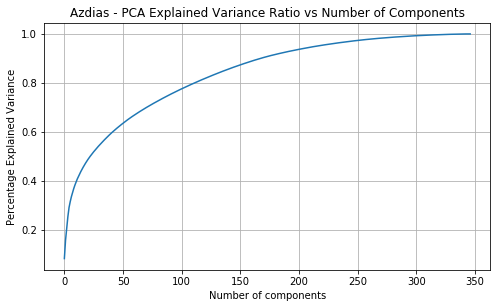

In [45]:
azdias_cleaned_variance = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
ax.plot(azdias_cleaned_variance)
ax.set_xlabel("Number of components")
ax.set_ylabel('Percentage Explained Variance')
ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
ax.grid()
plt.show()

In [46]:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.90)[0])
print(n_components)

168


In [47]:
# choose 168 variables
pca = PCA(168)
pca.fit(azdias_cleaned)
azdias_168 = pca.transform(azdias_cleaned)
customers_168 = pca.transform(customers_cleaned)

In [48]:
# We can take a look back at the ratio of variance explained by our components. 
pca.explained_variance_ratio_.sum()

0.89831802241768288

In [49]:
def component_n(pca, data, component_no):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys())
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig, ax = plt.subplots(figsize = (6,3))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_no-1, :].sort_values().iloc[[0, 1, 2, -3, -2, -1]].plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights (pos, neg)")
    ax.set_xticklabels(components.iloc[component_no-1, :].sort_values().index, rotation=90)
    

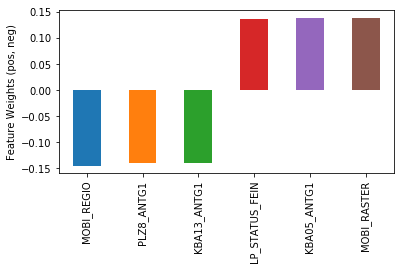

In [50]:
# component 1 Interpretation 
component_n(pca, azdias_cleaned, 1)

Component 1 <br>
Negative features: moving more often; sharing house with other families <br>
Positive features: high income

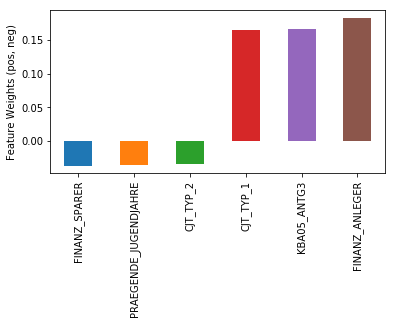

In [51]:
# component 2 Interpretation 
component_n(pca, azdias_cleaned, 2)

Component 2 <br>
postive features: low investing party <br>
negative features: money saver; older generation


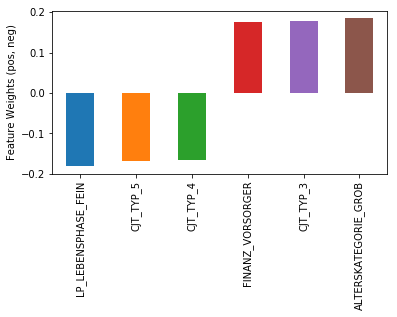

In [52]:
# component 3 Interpretation 
component_n(pca, azdias_cleaned, 3)

Component 3 <br>
Positive: financial prepared <br>
Negative: CJT_TYP_5 and CJT_TYP_4 (cannot find explaintion)


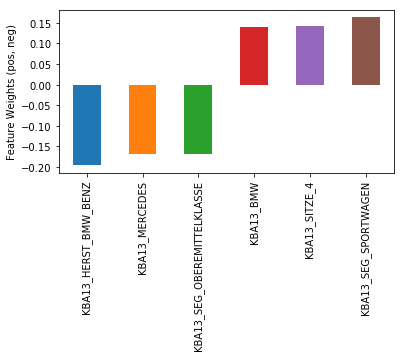

In [53]:
# component 4 Interpretation 
component_n(pca, azdias_cleaned, 4)

Component 4 Car type <br>
Positive: Sports car owner; BMW owner <br>
Negative: Mercedes owner


In [54]:
def elbow_func(data, n_start, n_end, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing n values from n_start to n_end every step value
    
    '''
    sse = []

    for i in range(n_start, n_end, step):
        kmeans = MiniBatchKMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        sse.append(abs(score))
        print("{} is finished".format(i))
    plt.plot(range(n_start, n_end, step), sse, marker='o', color='r');
    plt.xlabel('number of clusters');
    plt.ylabel('Sum of squared errors');
    plt.title('Sum of squared errors vs. No. of cluster');

1 is finished
4 is finished
7 is finished
10 is finished
13 is finished
16 is finished
19 is finished
22 is finished
25 is finished
28 is finished
31 is finished
34 is finished


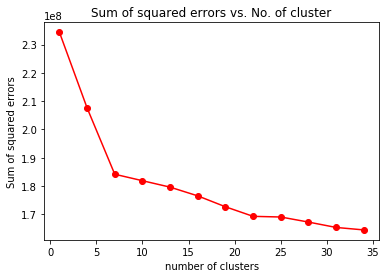

In [77]:
elbow_func(azdias_168, 1, 36, 3)

Based on the elbow graph above, I choose 16 as a reasonable number of cluster.

In [78]:
kmeans = KMeans(16)
cluster_model = kmeans.fit(azdias_168)

In [79]:
azdias_cluster = cluster_model.predict(azdias_168)
customer_cluster = cluster_model.predict(customers_168)
customer_cluster = pd.Series(customer_cluster)
azdias_cluster = pd.Series(azdias_cluster)

In [80]:
cluster = pd.DataFrame([])
cluster["azdias"] = azdias_cluster.value_counts().sort_index()
cluster["customer"] = customer_cluster.value_counts().sort_index()
cluster_proportion = pd.DataFrame([])
cluster_proportion['azdias'] = cluster["azdias"]/cluster['azdias'].sum()
cluster_proportion['customer'] = cluster["customer"]/cluster['customer'].sum()

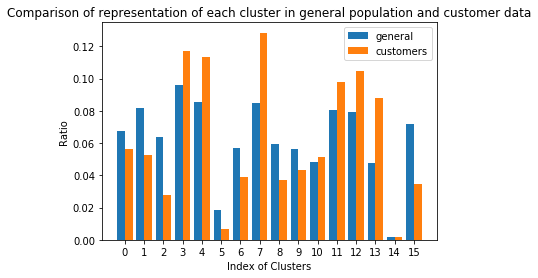

In [81]:
index = np.arange(16)
bar_width = 0.4
fig, ax = plt.subplots()
ax.bar(index, cluster_proportion["azdias"], bar_width, label = "general")
ax.bar(index+bar_width, cluster_proportion["customer"], bar_width, label = "customers")
ax.set_xlabel('Index of Clusters')
ax.set_ylabel('Ratio')
ax.set_title('Comparison of representation of each cluster in general population and customer data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.show()

Based on the comparsion graph above, we can tell that cluster 4, 12, 14 are overrepresented in customers dataset, and cluster 7, 13, 15 are underrepresented in customer dataset. I will look into each of these clusters respectively. 

In [60]:
def explain_cluster(kmeans_model, cluster_no, num_components=2):        
    weights = kmeans_model.cluster_centers_[cluster_no]    
    components = list(range(len(weights)))        
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})    
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)
    comps = []    
    weights = []    
    for index, row in cluster_expl.head(n=num_components).iterrows():        
        comps += [int(row["Component"])]        
        weights +=  [row["Weights"]]             
    df = pd.concat([pd.Series(weights), pd.Series(comps)], ignore_index=True)            
    return df

In [61]:
"""function cluster_components() will list the two most prominent components of this cluster"""
def cluster_components(model, cluster_no):    
    weights = model.cluster_centers_[cluster_no]    
    components = list(range(len(weights)))    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})    
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)    
    return cluster_expl[:2]

## Over Representation Cluster

In [82]:
cluster_components(cluster_model, 7)

,Weights,Component
1,0.959620,1
3,0.948558,3


In [83]:
cluster_components(cluster_model, 13)

,Weights,Component
5,1.826480,5
7,1.611521,7


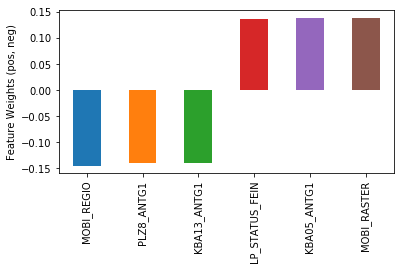

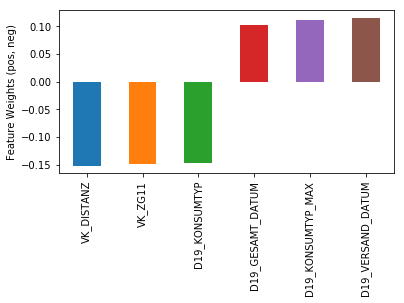

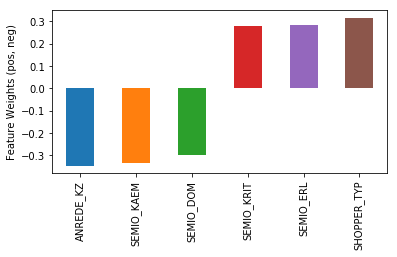

In [65]:
component_n(pca, azdias_cleaned, 1)
component_n(pca, azdias_cleaned, 5)
component_n(pca, azdias_cleaned, 7)

Based on the components above, we can get some insights about characteristics of existing customers:

1.High income with less home moving

2.High transaction of mail-order over the past 12 months

3.High transaction activity TOTAL POOL in the last 12 months

4.People who is less critical minded, less event-oriented, more dominant mineded and more with a fightful attitude. 

5.Family shopper, demanding shopper

## Under Representation Cluster

In [84]:
cluster_components(cluster_model, 2)

,Weights,Component
3,5.596022,3
0,5.079054,0


In [85]:
cluster_components(cluster_model, 15)

,Weights,Component
0,4.847072,0
2,2.384620,2


In [76]:
cluster_components(cluster_model, 8)

,Weights,Component
0,4.809255,0
2,2.444621,2


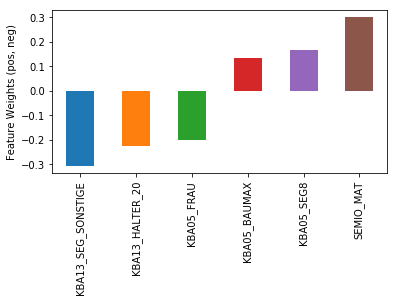

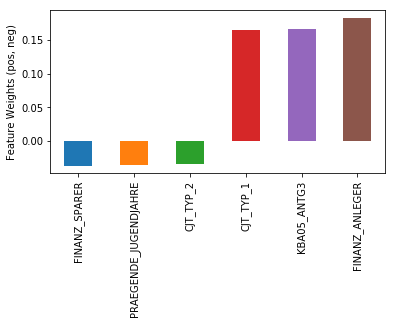

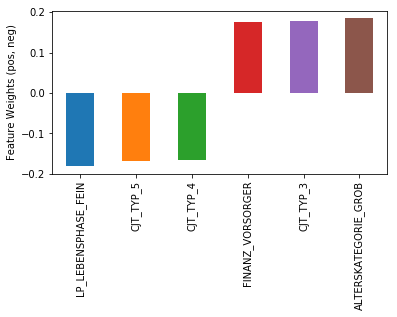

In [69]:
component_n(pca, azdias_cleaned, 0)
component_n(pca, azdias_cleaned, 2)
component_n(pca, azdias_cleaned, 3)

Based on the components above, we can get some insights about population who are less likely to be our customers:

1.People who cares about environmental sustainability in the youth

2.People who are more a money saver

3.People who has higher share of 1-2 family homes

4.People who is less likely an investor

5.People at younger age

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [88]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [89]:
mailout_train.shape

(42962, 367)

0    42430
1      532
Name: RESPONSE, dtype: int64


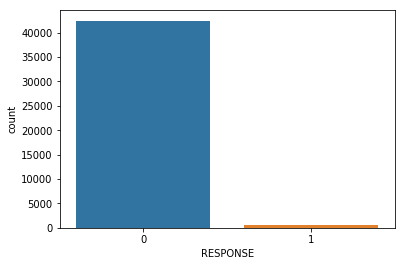

In [90]:
sns.countplot(mailout_train['RESPONSE'])
print(mailout_train['RESPONSE'].value_counts())

From the countplot above we can tell this is a very imbalanced dataset, with 42430 negative and only 532 positive. <br>
As for evaluation metric for imbalanced data prediction, we need to carefully select because accuracy won't get us what we want, e.g. with labeling all the response as negative, the model will get an accuracy of (42430-532)/42430 is almost 100%. Obviouly we are not happy with a model like that. We want a model to better divide positive from negative, both True Positive (TP) and True Negative (TN) are important.
For such an imbalanced classification problem, AUROC (Area Under Receiver Operating Curve) is highly recommended. I will use AUROC as my evalution metric. 


<b>AUROC</b> <br>
The AUROC is calculated as the area under the ROC curve. A ROC curve shows the trade-off between true positive rate (TPR) and false positive rate (FPR) across different decision thresholds.

## Data cleaning

In [91]:
# Same as the cleaning steps in the former cluster part. 
response = mailout_train['RESPONSE']
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].replace({'X': np.nan})
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].replace({'XX': np.nan})
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].astype(float)
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].astype(float)

#take a look at attribute intro file 
attribute_values.reset_index(drop = True, inplace = True)
# not all the variables have unknown value and not all of them note it with 0 or 1
unknown_attributes = attribute_values[(attribute_values['Meaning'] == 'unknown')\
                                       |(attribute_values['Meaning']=='no classification possible')\
                                      |(attribute_values['Meaning']=='no score calculated')\
                                      |(attribute_values['Meaning']=='no transactions known')\
                                      |(attribute_values['Meaning']=='no transaction known')]

In [92]:
unknown_cols = unknown_attributes[['Attribute', 'Value']]
df1=pd.DataFrame.from_records(unknown_cols.values)
#create a dict for unknown values
unknown_dict = df1.set_index(0).T.to_dict('list')
mailout_train = lp_refine(mailout_train)
mailout_train['CAMEO_DEU_2015'] = mailout_train['CAMEO_DEU_2015'].replace({'XX': np.nan})
mailout_train = missing_value(mailout_train)
mailout_train_missing_df = missing_percentage(mailout_train)
col_to_remove_mailout_train = [col for col in mailout_train_missing_df[mailout_train_missing_df['percentage']>0.3]['attribute']]
mailout_train.drop(columns = col_to_remove_mailout_train, inplace = True)
mailout_train["OST_WEST_KZ"] = mailout_train["OST_WEST_KZ"].replace({"W": 0, "O": 1})
mailout_train.drop(columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], inplace = True)
mailout_train.set_index('LNR')
mailout_train = date_refine(mailout_train)
mailout_train = imputation(mailout_train)
scaler = StandardScaler()
mailout_train= pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)
# replace the response into its original non-standardized form
mailout_train['RESPONSE'] = response

In [93]:
mailout_train.drop('RESPONSE', axis =1, inplace  = True)

In [94]:
mailout_train.isnull().values.any()

False

In [95]:
print(mailout_train.shape)
print(response.shape)

(42962, 347)
(42962,)


In [96]:
mailout_train.set_index('LNR')

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
-1.656309,-0.274048,-0.091614,-0.428455,0.671637,-0.116979,-0.204857,-0.656284,0.585171,-0.083831,-0.220509,...,-0.297077,0.395528,-0.584315,-0.720097,0.658279,0.243200,-0.457589,0.174577,0.824885,0.736410
-1.655987,1.594293,0.650673,0.837103,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-1.214166,...,0.663993,-0.877594,-0.584315,-0.720097,-0.465945,0.243200,1.651457,-1.608634,0.824885,-0.200391
-1.655785,-0.274048,0.056844,-0.681567,-0.408533,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,-1.258147,0.713809,0.026598,-0.310691,0.658279,0.243200,-0.984851,0.174577,-1.212290,0.736410
-1.668538,-0.274048,-0.388528,-0.934679,-0.120488,-0.116979,-0.204857,0.113910,-0.100649,-0.083831,0.773148,...,1.625063,1.350369,2.164794,3.373970,0.658279,0.243200,-1.512113,0.174577,0.824885,0.736410
-1.655502,-0.274048,0.056844,-0.175344,3.408069,-0.116979,-0.204857,-0.656284,2.947442,-0.083831,-0.220509,...,1.625063,-0.559313,-0.584315,-0.720097,0.658279,0.243200,-0.457589,0.174577,-1.212290,-0.200391
-1.655260,-0.274048,0.502216,0.583992,0.815660,-0.116979,-0.204857,-0.656284,0.432767,-0.083831,0.773148,...,1.625063,-0.559313,-0.889771,-0.720097,0.658279,0.243200,-0.984851,0.174577,0.824885,-0.200391
-1.655018,-0.274048,-0.091614,-0.428455,-0.264510,-0.116979,-0.204857,-0.656284,-0.329256,-0.083831,-0.220509,...,-1.258147,0.713809,0.637511,0.098716,0.658279,0.243200,-0.984851,0.174577,0.824885,0.736410
-1.667206,-0.274048,0.650673,0.837103,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-2.207823,...,-2.219217,-0.877594,-0.889771,-0.720097,0.658279,0.243200,1.651457,0.174577,0.824885,0.736410
-1.654776,-0.274048,-1.279272,-0.175344,-0.336522,-0.116979,-0.204857,-0.656284,-0.329256,-0.083831,0.773148,...,-0.297077,-0.877594,-0.889771,-0.720097,0.658279,0.243200,-0.457589,0.174577,0.824885,-0.200391


 The next step is split training and testing and cross validation. 

In [109]:
X = mailout_train
y = response

In [100]:
def make_pipeline(model):
    pipeline = Pipeline([('classifier', model)])
    return pipeline

In [102]:
def learning_curve_plot(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=None, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
    print("Roc_auc test score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()
    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend()
    print("")
    plt.show()


In [103]:
models = {'LogisticRegression': LogisticRegression(random_state = 7), 
          'RandomForestClassifier': RandomForestClassifier(random_state=7), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=7), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=7)
         }

LogisticRegression
Roc_auc train score = 0.83
Roc_auc test score = 0.65



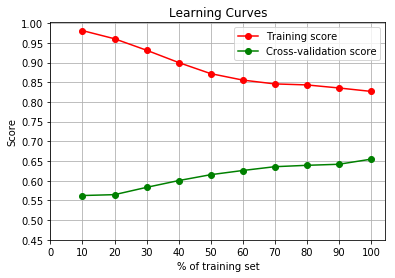

RandomForestClassifier
Roc_auc train score = 1.0
Roc_auc test score = 0.51



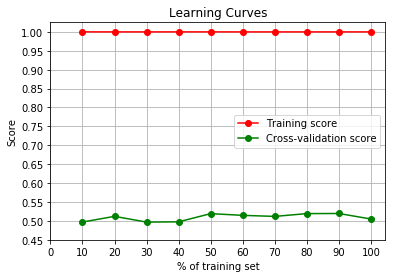

AdaBoostClassifier
Roc_auc train score = 0.85
Roc_auc test score = 0.71



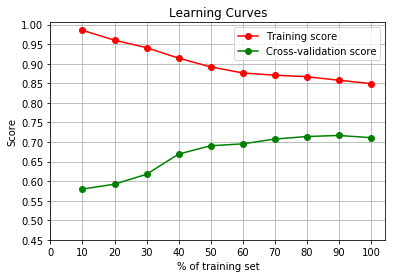

GradientBoostingClassifier
Roc_auc train score = 0.92
Roc_auc test score = 0.75



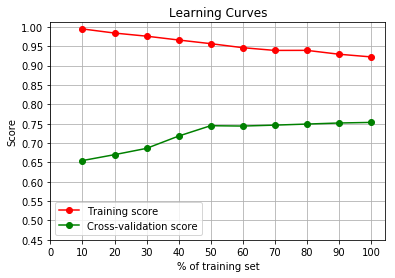

In [104]:
for model in models.keys():
    print(model)
    pipeline = make_pipeline(models[model])
    learning_curve_plot(X, y, pipeline, 10)

Comparison of performance of four model on training and testing data

|Model | Roc_auc train score | Roc_auc test score
| ------------- |:-------------:| -----:|
|Logistic Regression |0.83| 0.65
|Random Forest Classifier |1.0| 0.51
|AdaBoost Classifier |0.85 |0.71
|Gradient Boosting Classifier |0.92|0.75


<b>Gradient Boosting Classifier</b> has the best performance of 0.75 on test data, and good performance on training data. It will be my target model for kaggle submission. <br>
<b>Logistic Regression</b> has a solid performance and since two curves are not converging yet, I believe with more training and testing data, we can achieve better results from this model.<br>
<b>Random forest</b> shows overfitting pattern with high AUROC on training data and AUROC (50%) on testing data. <br>
<b>AdaBoost Classifier</b> has an overal good performance. 

In [110]:
# Grid search to find the best hyper parameters for Gradient boost classifier. 
gbc = make_pipeline(GradientBoostingClassifier(random_state=3))
parameters = {'classifier__learning_rate': [0.1, 0.2], 
              'classifier__n_estimators': [100], 
              'classifier__max_depth': [3, 5], 
              'classifier__min_samples_split': [2, 4]}
grid = GridSearchCV(gbc, parameters, scoring = 'roc_auc')

In [111]:
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=...        presort='auto', random_state=3, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__learning_rate': [0.1, 0.2], 'classifier__n_estimators': [100], 'classifier__max_depth': [3, 5], 'classifier__min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [128]:
estimators = grid.best_estimator_
best_predictions = estimators.predict_proba(X)[:, 1]
predictions = (gbc.fit(X, y)).predict_proba(X)[:, 1]
print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y, predictions)))
#print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

Roc_auc score on training data: 0.8908


In [129]:
pkl_filename = "gbc_model.pkl"  
with open(pkl_filename, 'wb') as model:  
    pickle.dump(estimators, model)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [158]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [145]:
mailout_test.shape

(42833, 366)

In [146]:
# Same as the cleaning steps in the former cluster part. 
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].replace({'X': np.nan})
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].replace({'XX': np.nan})
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].astype(float)
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].astype(float)
attribute_values.reset_index(drop = True, inplace = True)
# not all the variables have unknown value and not all of them note it with 0 or 1
unknown_attributes = attribute_values[(attribute_values['Meaning'] == 'unknown')\
                                       |(attribute_values['Meaning']=='no classification possible')\
                                      |(attribute_values['Meaning']=='no score calculated')\
                                      |(attribute_values['Meaning']=='no transactions known')\
                                      |(attribute_values['Meaning']=='no transaction known')]

In [147]:
unknown_cols = unknown_attributes[['Attribute', 'Value']]
df=pd.DataFrame.from_records(unknown_cols.values)
#create a dict for unknown values
unknown_dict = df.set_index(0).T.to_dict('list')
mailout_test = lp_refine(mailout_test)
mailout_test['CAMEO_DEU_2015'] = mailout_test['CAMEO_DEU_2015'].replace({'XX': np.nan})
mailout_test = missing_value(mailout_test)
mailout_test_missing_df = missing_percentage(mailout_test)
col_to_remove_mailout_test = [col for col in mailout_test_missing_df[mailout_test_missing_df['percentage']>0.3]['attribute']]
mailout_test.drop(columns = col_to_remove_mailout_test, inplace = True)
mailout_test["OST_WEST_KZ"] = mailout_test["OST_WEST_KZ"].replace({"W": 0, "O": 1})
mailout_test.drop(columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], inplace = True)
mailout_test.set_index('LNR')
mailout_test = date_refine(mailout_test)
mailout_test = imputation(mailout_test)
scaler = StandardScaler()
mailout_test= pd.DataFrame(scaler.fit_transform(mailout_test), columns = mailout_train.columns)

In [148]:
model_package = "gbc_model.pkl"  
with open(model_package, 'rb') as file:  
    gbc_model = pickle.load(file) 
prediction = gbc_model.predict_proba(mailout_test)[:,1]

In [149]:
prediction = pd.Series(prediction)

In [156]:
prediction.to_csv('prediction.csv')

In [163]:
submission = pd.concat([mailout_test.LNR, prediction], axis=1).reset_index()

In [166]:
submission.to_csv('submission.csv')